In [2]:
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%pylab inline

greendata = pd.read_csv('greenbuildings.csv')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


The original argument assumes that the green building will be making profit for an additional 30 years (after recouping the initial costs). Assuming a time span of roughly 40 years after the initial construction, is the positive revenue stream from rent within this time period for green buildings a reasonable assumption? Could rent price for green buildings be related to other variables that could actually make the business lose money?

To preprocess the data, we agree with the leasing rate condition to remove outliers that have very low leasing rates that may be due to uncommon reasons. In addition to this, we also found that there are data points for particularly old buildings compared to the mean age of buildings in the data set, which we removed. 

In [3]:
#Removing the data points with leasing rates < 10% and age > 120 to clean data
print(greendata['age'].mean())
greendata = greendata[(greendata['leasing_rate'] > 10) & (greendata['age'] < 120)]


47.24398277172536


Let's make a correlation matrix between rent and other variables for all building types to conduct further analysis.

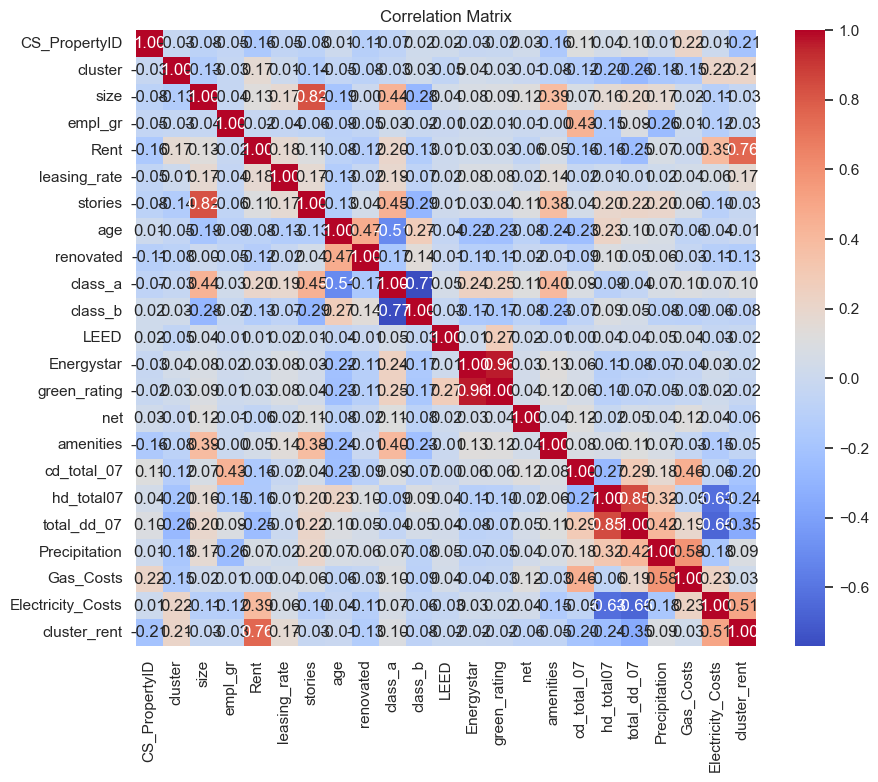

In [4]:
# Calculate the correlation matrix
correlation_matrix = greendata.corr()

# Set up the style of the plot
plt.figure(figsize=(10, 8))
sns.set(style="white")

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Set the title
plt.title("Correlation Matrix")

# Show the plot
plt.show()

From the correlation matrix above, it seems that rent price for all buildings is most positively correlated with cluster_rent and electricity_costs. This assumption makes sense because rent of a building is usually determined by the cluster of buildings nearby and electricity prices could drastically impact how much a tenant has to pay for rent.

However, green buildings may react differently to changes in cluster_rent and electricity_costs in comaprison to non-green buildings. To prove this, let's split up green-buildings and non-green-buildings and see if cluster rent and electricity costs impacts green buildings differently from traditional buildings.

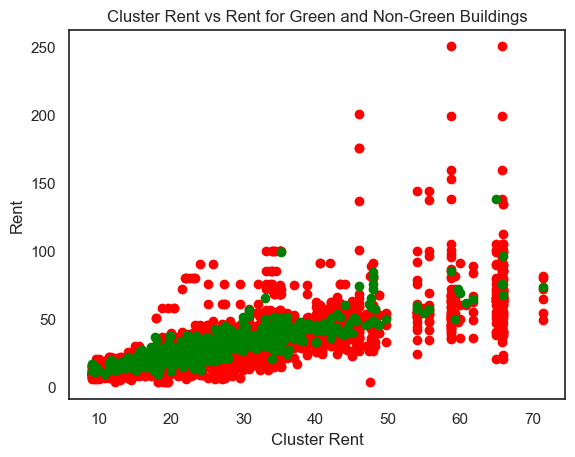

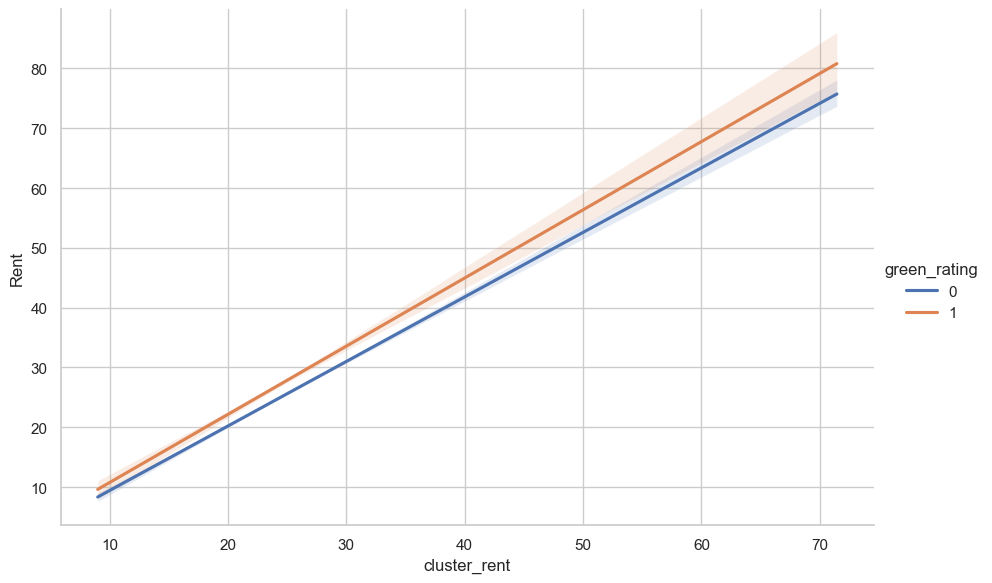

In [5]:
green_rated = greendata[greendata['green_rating']==1]
non_green_rated = greendata[greendata['green_rating'] != 1]

#CLUSTER RENT 
# Create a scatter plot
plt.scatter(non_green_rated['cluster_rent'], non_green_rated['Rent'], label='Non-green rated buildings', color='red')
plt.scatter(green_rated['cluster_rent'], green_rated['Rent'], label='Green rated buildings', color='green')

# Add labels and title
plt.xlabel('Cluster Rent')
plt.ylabel('Rent')
plt.title('Cluster Rent vs Rent for Green and Non-Green Buildings')

sns.set(style='whitegrid')
g=sns.lmplot(data=greendata,x='cluster_rent',y='Rent',hue='green_rating',scatter=False,height=6,aspect=1.5)


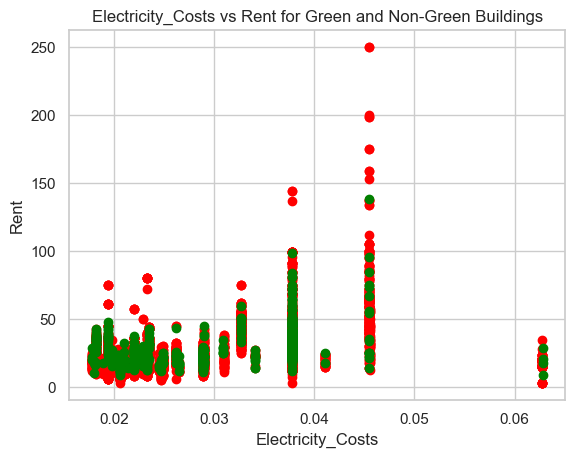

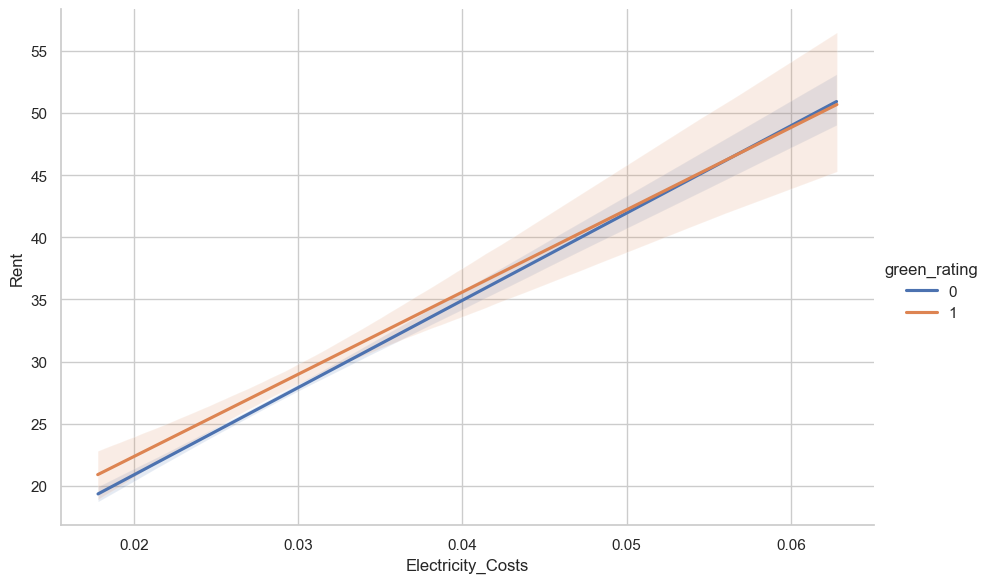

In [6]:
#ELECTRICITY COSTS 
# Create a scatter plot
plt.scatter(non_green_rated['Electricity_Costs'], non_green_rated['Rent'], label='All buildings', color='red')
plt.scatter(green_rated['Electricity_Costs'], green_rated['Rent'], label='Green rated buildings', color='green')

# Add labels and title
plt.xlabel('Electricity_Costs')
plt.ylabel('Rent')
plt.title('Electricity_Costs vs Rent for Green and Non-Green Buildings')

sns.set(style='whitegrid')
g=sns.lmplot(data=greendata,x='Electricity_Costs',y='Rent',hue='green_rating',scatter=False,height=6,aspect=1.5)

From the graphs above, green buildings' rent seem to act similarly to non green buildings' rent with changes in cluster rent and electricity costs.

Thus, there aren't any striking confounding variables to account for with the information provided. However, the correlation map did show a slightly positive correlation for green buildings and class_A building. Given that our building is brand new and near a downtown area and that it might be considered class_A when constructed, we added this condition to inform our rent comparison. 

green_rating
0    25.2
1    27.6
Name: Rent, dtype: float64
green_rating     0       1
class_a                   
0             24.0  25.675
1             28.2  28.440


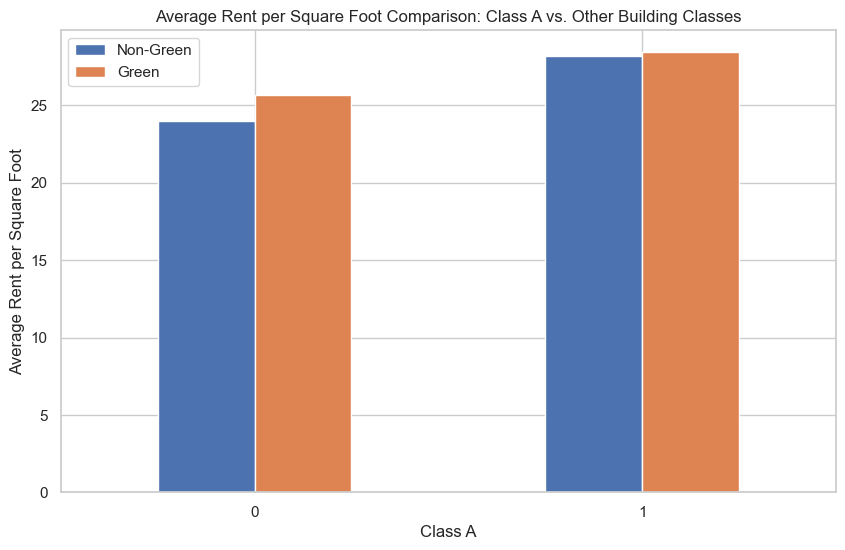

In [7]:
# Group by green rating and calculate the average rent for each class without class_A
class_avg_rent_1 = greendata.groupby('green_rating')['Rent'].median()
print(class_avg_rent_1)


# Group by building class and green_rating, and calculate the average rent per square foot for each category
class_avg_rent = greendata.groupby(['class_a', 'green_rating'])['Rent'].median().unstack()
print(class_avg_rent)

# Plotting the comparison for Class A and other classes
class_avg_rent.plot(kind='bar', figsize=(10, 6))
plt.title('Average Rent per Square Foot Comparison: Class A vs. Other Building Classes')
plt.xlabel('Class A')
plt.ylabel('Average Rent per Square Foot')
plt.xticks(rotation=0)
plt.legend(['Non-Green', 'Green'])
plt.show()

Without accounting for class A, the difference is very close to the 2.6 dollar increase for green building rent found by your statistician. However, if we hold this assumption, the difference is actually much smaller with the difference being only 0.24. 

In [8]:
difference = 28.440 - 28.2
extra_revenue = 250000*difference
extra_revenue

60000.000000000495

This extra revenue of approximately 60000 is significantly less than the 650000 found by the statistician when accounting for class_a as a confounding variable. Let us see how long it will take to recouperate the costs based on the adjusted average leasing rate. 

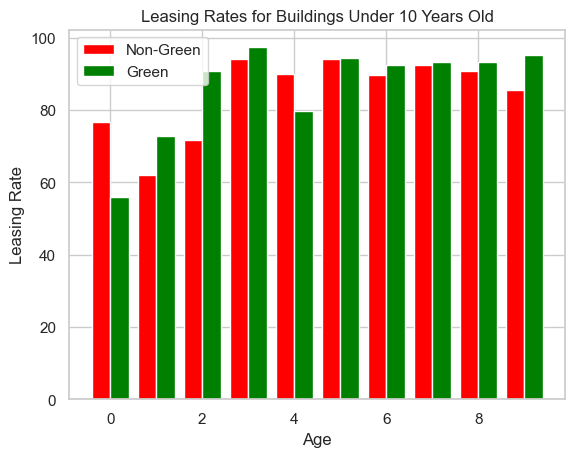

In [12]:
class_a_green_data = greendata[greendata['class_a']==1]
mask = class_a_green_data['age'] < 10
age_under_10 = class_a_green_data[mask]

mask2 = age_under_10['green_rating'] == 1
green_under_10 = age_under_10[mask2]

mask3 = age_under_10['green_rating'] == 0
nongreen_under_10 = age_under_10[mask3]

#Use of mean average instead of median to allow weightage to the differences across a short period of time. 

grouped_data_nongreen = nongreen_under_10.groupby('age')['leasing_rate'].mean().reset_index()
grouped_data_nongreen = grouped_data_nongreen.set_index('age')

grouped_data_green = green_under_10.groupby('age')['leasing_rate'].mean().reset_index()
grouped_data_green = grouped_data_green.set_index('age')

width = 0.4

plt.bar(grouped_data_nongreen.index - width/2, grouped_data_nongreen['leasing_rate'], width, color='red')
plt.bar(grouped_data_green.index + width/2, grouped_data_green['leasing_rate'], width, color='green')
plt.title('Leasing Rates for Buildings Under 10 Years Old')
plt.xlabel('Age')
plt.ylabel('Leasing Rate') 
plt.legend(['Non-Green', 'Green'])
plt.show()

In [13]:
avg_lease_rate_nongreen = grouped_data_nongreen['leasing_rate'].mean()
avg_lease_rate_green = grouped_data_green['leasing_rate'].mean()

print('Average leasing rate for non-green buildings in their first 10 years:', avg_lease_rate_nongreen)
print('Average leasing rate for green buildings in their first 10 years:', avg_lease_rate_green)

Average leasing rate for non-green buildings in their first 10 years: 84.66738022146936
Average leasing rate for green buildings in their first 10 years: 86.5084149322169


In [14]:
green_premium = 100000000 * 0.05
yearly_revenue = extra_revenue * (avg_lease_rate_green / 100)

years_to_recoup = green_premium / yearly_revenue

print(f'At the average lease rate for the first 10 years of a green building, it would take {years_to_recoup} years to recoup the green premium')

At the average lease rate for the first 10 years of a green building, it would take 96.32974248647133 years to recoup the green premium


Based on this analysis, there are some holes in the statistician's inference. Without any confounding variables, his estimates are roughly accurate and point towards supporting the green certification. However, if we hold the assumption that this building will be class_a, the differences are major. It earns much less extra revenue that takes around 80 years more to recouperate the costs than originally predicted. Based on these two factors alone, it might not be that beneficial to get the green certification. However, this analysis is still very limited. If we knew what cluster the building would be in, this might help benefit our analysis. An example graph is shown below. 

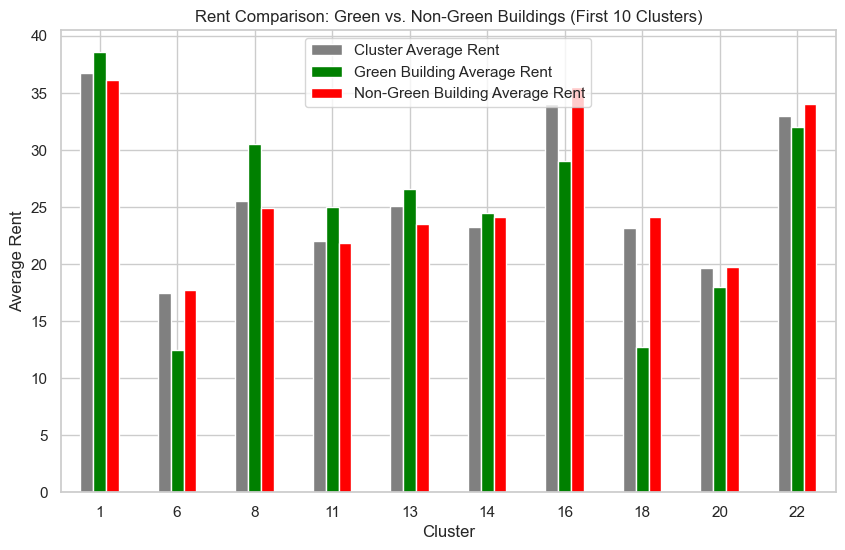

In [15]:
# Calculate the average rent for green and non-green buildings in each cluster
green_avg_rent = greendata[greendata['green_rating'] == 1].groupby('cluster')['Rent'].mean()
non_green_avg_rent = greendata[greendata['green_rating'] == 0].groupby('cluster')['Rent'].mean()

# Assuming you already have cluster average rent
cluster_avg_rent = greendata.groupby('cluster')['cluster_rent'].first()

# Combine the results into a single DataFrame
analysis_result = pd.DataFrame({
    'Cluster Average Rent': cluster_avg_rent,
    'Green Building Average Rent': green_avg_rent,
    'Non-Green Building Average Rent': non_green_avg_rent
})

# Plotting the first 10 clusters
analysis_result.head(10).plot(kind='bar', figsize=(10, 6),color=('grey','green','red'))
plt.title('Rent Comparison: Green vs. Non-Green Buildings (First 10 Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Average Rent')
plt.xticks(rotation=0)
plt.legend()
plt.show()


With the information provided, the statiscian's inference made sense without accounting for confounding variables. The one we found to impact green buildings was class_a, and using this condition made our inference drastically different, where we suggest not to invest in the green certification as the rent benefits are not enough to substantiate the costs 